<a href="https://colab.research.google.com/github/sottohy/Sperm-Embryo-classification-models/blob/main/Embryo_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from shutil import copyfile, move
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil
import random
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

img_width, img_height = 130, 130
batch_size = 32




es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)

In [ ]:
import os
import shutil

# Paths to the embryo data folders on Google Drive
ed1_path = "/content/drive/MyDrive/GP/datasetEmbryos/ed1"
ed2_path = "/content/drive/MyDrive/GP/datasetEmbryos/ed2"
ed3_path = "/content/drive/MyDrive/GP/datasetEmbryos/ed3"
ed4_path = "/content/drive/MyDrive/GP/datasetEmbryos/ed4"

# Destination paths for training and testing data
base_path = "/content/drive/MyDrive/GP/train-test"
train_path = os.path.join(base_path, "training_data")
test_path = os.path.join(base_path, "testing_data")

# Create training and testing directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

def copy_embryo_data(source_path, destination_path, split_ratio):
    # Iterate over each ed folder (ed1, ed2, ed3, ed4)
    for ed_folder in os.listdir(source_path):
        ed_folder_path = os.path.join(source_path, ed_folder)

        # Create folders for Good and Bad in training and testing
        for folder in ["Good", "Bad"]:
            os.makedirs(os.path.join(destination_path, folder), exist_ok=True)

        # Load labels from the corresponding text file
        label_mapping = load_labels_from_text_file(ed_folder_path)

        # Get the list of subfolders (1 to 5) in the current ed folder
        subfolders = [subfolder for subfolder in os.listdir(os.path.join(ed_folder_path, 'alldata')) if os.path.isdir(os.path.join(ed_folder_path, 'alldata', subfolder))]

        # Iterate over subfolders
        for subfolder in subfolders:
            subfolder_path = os.path.join(ed_folder_path, 'alldata', subfolder)

            # Get the list of image files in the current subfolder
            image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Calculate split index
            split_index = int(len(image_files) * split_ratio)

            # Copy images to destination paths
            for file in image_files[:split_index]:
                src_file = os.path.join(subfolder_path, file)

                # Check if the file exists in the label mapping
                if file in label_mapping:
                    # Adjust the label mapping based on the specific condition
                    if ed_folder in ['ed1', 'ed2']:
                        label = int(label_mapping[file])
                        dst_folder = "Bad" if label in [0, 1] else "Good" if label in [2, 3, 4] else None
                    elif ed_folder in ['ed3', 'ed4']:
                        label = int(label_mapping[file])
                        dst_folder = "Bad" if label == 0 else "Good" if label == 1 else None
                    else:
                        dst_folder = None

                    if dst_folder is not None:
                        dst_file = os.path.join(destination_path, dst_folder, file)
                        shutil.copy(src_file, dst_file)
                        print(f"Copying {file} to {dst_folder}")
                else:
                    print(f"Label not found for {file} in {ed_folder_path}")

def load_labels_from_text_file(ed_folder_path):
    label_mapping = {}

    # Construct the path to the labeled text file based on the ed_folder_path
    target_file_path = os.path.join(ed_folder_path, f'{os.path.basename(ed_folder_path)}_target.txt')

    # Check if the target file exists
    if not os.path.isfile(target_file_path):
        print(f"Target file not found: {target_file_path}")
        return label_mapping

    with open(target_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            parts = line.strip().split(' ')
            image_filename = parts[0].split("/")[-1]  # Extract the filename from the path
            label = parts[1]  # The label is the second part of the line

            # Save label to mapping
            label_mapping[image_filename] = int(label)

    return label_mapping


# Debugging information
label_mapping_debug = load_labels_from_text_file(ed4_path)
for file, label in label_mapping_debug.items():
    print(f"File: {file}, Label: {label}")


# Debugging information
label_mapping_debug = load_labels_from_text_file(ed4_path)
for file, label in label_mapping_debug.items():
    print(f"File: {file}, Label: {label}")


# Copy data for each ed folder
copy_embryo_data(ed1_path, train_path, split_ratio=0.9)
copy_embryo_data(ed1_path, test_path, split_ratio=0.1)

copy_embryo_data(ed2_path, train_path, split_ratio=0.9)
copy_embryo_data(ed2_path, test_path, split_ratio=0.1)

copy_embryo_data(ed3_path, train_path, split_ratio=0.9)
copy_embryo_data(ed3_path, test_path, split_ratio=0.1)

copy_embryo_data(ed4_path, train_path, split_ratio=0.9)
copy_embryo_data(ed4_path, test_path, split_ratio=0.1)


Target file not found: /content/drive/MyDrive/GP/datasetEmbryos/ed4/ed4_target.txt
Target file not found: /content/drive/MyDrive/GP/datasetEmbryos/ed4/ed4_target.txt
Copying 17.png to Good
Copying 14.png to Good
Copying 6.png to Good
Copying 16.png to Good
Copying 19.png to Good
Copying 32.png to Good
Copying 58.png to Good
Copying 44.png to Good
Copying 50.png to Good
Copying 41.png to Good
Copying 53.png to Good
Copying 28.png to Good
Copying 59.png to Good
Copying 65.png to Good
Copying 31.png to Good
Copying 21.png to Good
Copying 62.png to Good
Copying 49.png to Good
Copying 68.png to Good
Copying 25.png to Good
Copying 38.png to Good
Copying 36.png to Good
Copying 82.png to Good
Copying 120.png to Good
Copying 79.png to Good
Copying 92.png to Good
Copying 104.png to Good
Copying 131.png to Good
Copying 116.png to Good
Copying 76.png to Good
Copying 72.png to Good
Copying 108.png to Good
Copying 74.png to Good
Copying 86.png to Good
Copying 80.png to Good
Copying 98.png to Good
Co

In [ ]:
base_path = "/content/drive/MyDrive/GP/train-test"
train_path = os.path.join(base_path, "training_data")
test_path = os.path.join(base_path, "testing_data")

local_train_path = "/content/local_dataset11/train"
local_test_path = "/content/local_dataset11/test"


os.makedirs(local_train_path, exist_ok=True)
os.makedirs(local_test_path, exist_ok=True)

def copy_data(source_path, destination_path):
    files = os.listdir(source_path)

    # Create the destination path if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Copy files to destination paths
    for file in files:
        src_file = os.path.join(source_path, file)
        dst_file = os.path.join(destination_path, file)

        # Check if the source is a directory
        if os.path.isdir(src_file):
            # Recursively copy the directory
            copy_data(src_file, dst_file)
        else:
            # Copy the file
            shutil.copy(src_file, dst_file)

# Copy data for training
copy_data(train_path, local_train_path)

# Copy data for testing
copy_data(test_path, local_test_path)


In [ ]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.,
    rescale=1./255,
    validation_split=0.1,  # Change validation_split to 10%
    width_shift_range=0.2,
    height_shift_range=0.2
)
# Create generators for training, validation, and test sets
train_generator = datagen.flow_from_directory(
    "/content/local_dataset11/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "/content/local_dataset11/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   "/content/local_dataset11/test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)




Found 864 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


Epoch 1/50
27/27 [==============================] - 25s 781ms/step - loss: 0.6041 - accuracy: 0.7083 - val_loss: 14.9988 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 2/50
27/27 [==============================] - 23s 837ms/step - loss: 0.4599 - accuracy: 0.8160 - val_loss: 14.0520 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 3/50
27/27 [==============================] - 21s 765ms/step - loss: 0.4132 - accuracy: 0.8275 - val_loss: 11.1246 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 4/50
27/27 [==============================] - 20s 729ms/step - loss: 0.3807 - accuracy: 0.8299 - val_loss: 0.3189 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 5/50
27/27 [==============================] - 18s 671ms/step - loss: 0.3592 - accuracy: 0.8449 - val_loss: 9.0945 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 6/50
27/27 [==============================] - 19s 688ms/step - loss: 0.3889 - accuracy: 0.8380 - val_loss: 10.0658 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 7/50
27/27 [==============================] - 20s 730m

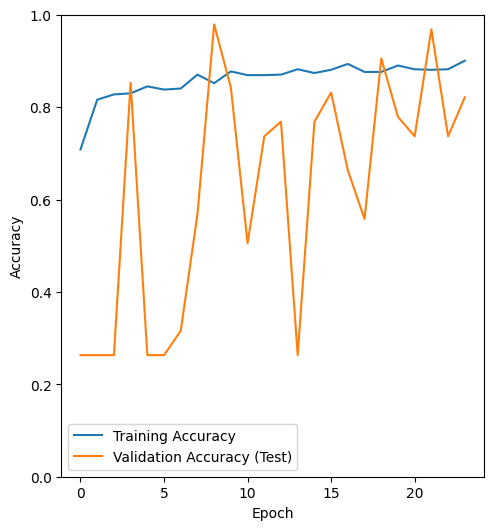

In [ ]:
# CNN  accuracy 0.836%
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam


model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(130, 130, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))


optimizer = Nadam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator,
                    epochs=50,
                     callbacks=[es_callback, reduce_lr],
                     validation_data=validation_generator,
                     verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training accuracy and validation accuracy (test accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])


plt.show()

Epoch 1/50
27/27 [==============================] - 7s 166ms/step - loss: 0.5094 - accuracy: 0.7789 - val_loss: 8.8861 - val_accuracy: 0.2632 - lr: 0.0100
Epoch 2/50
27/27 [==============================] - 5s 197ms/step - loss: 0.4056 - accuracy: 0.8137 - val_loss: 2.5666 - val_accuracy: 0.7368 - lr: 0.0100
Epoch 3/50
27/27 [==============================] - 5s 182ms/step - loss: 0.3740 - accuracy: 0.8449 - val_loss: 2.8838 - val_accuracy: 0.5053 - lr: 0.0100
Epoch 4/50
27/27 [==============================] - 5s 167ms/step - loss: 0.3074 - accuracy: 0.8704 - val_loss: 0.8926 - val_accuracy: 0.6947 - lr: 0.0100
Epoch 5/50
27/27 [==============================] - 6s 211ms/step - loss: 0.2616 - accuracy: 0.8866 - val_loss: 1.4551 - val_accuracy: 0.5684 - lr: 0.0100
Epoch 6/50
27/27 [==============================] - 4s 165ms/step - loss: 0.2805 - accuracy: 0.8831 - val_loss: 0.0425 - val_accuracy: 0.9789 - lr: 0.0100
Epoch 7/50
27/27 [==============================] - 6s 210ms/step - lo

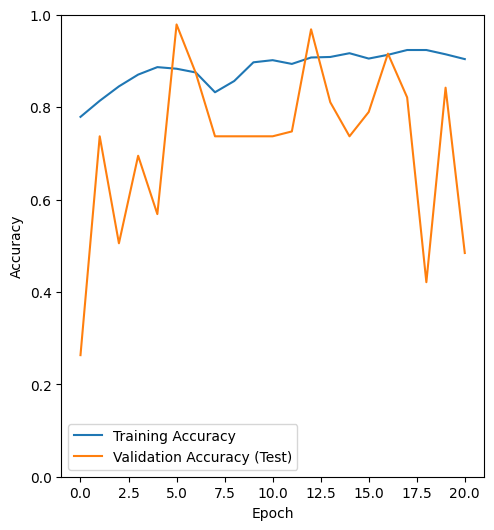

In [ ]:
# CNN  accuracy 0.84%    hlwaaa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam


model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(130, 130, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))


optimizer = Nadam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator,
                    epochs=50,
                     callbacks=[es_callback, reduce_lr],
                     validation_data=validation_generator,
                     verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training accuracy and validation accuracy (test accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])


plt.show()

8/8 [==============================] - 2s 203ms/step


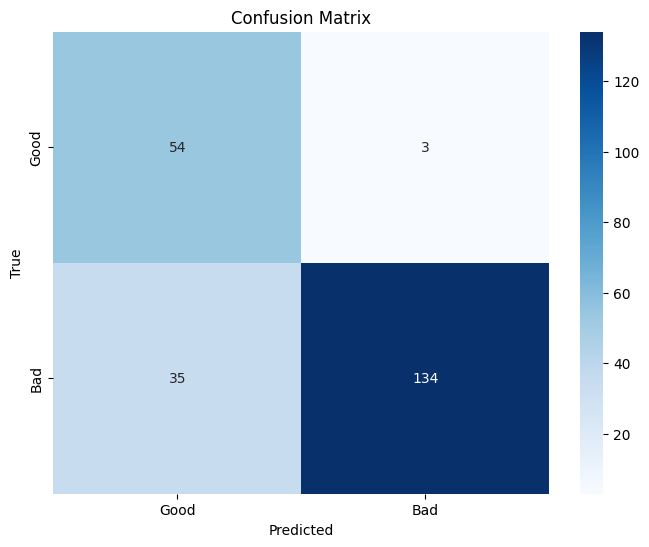

Classification Report:
               precision    recall  f1-score   support

        Good       0.61      0.95      0.74        57
         Bad       0.98      0.79      0.88       169

    accuracy                           0.83       226
   macro avg       0.79      0.87      0.81       226
weighted avg       0.88      0.83      0.84       226



In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred)

y_true = test_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=["Good", "Bad"])
print("Classification Report:\n", class_report)



plt.show()

Epoch 1/50
27/27 [==============================] - 9s 210ms/step - loss: 0.4807 - accuracy: 0.7836 - val_loss: 0.6225 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 5s 183ms/step - loss: 0.3629 - accuracy: 0.8600 - val_loss: 0.4787 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 7s 279ms/step - loss: 0.2779 - accuracy: 0.9097 - val_loss: 0.6131 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 6s 205ms/step - loss: 0.2326 - accuracy: 0.9178 - val_loss: 0.2972 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 5s 193ms/step - loss: 0.2246 - accuracy: 0.9213 - val_loss: 0.3824 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 5s 183ms/step - loss: 0.2075 - accuracy: 0.9259 - val_loss: 2.2319 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 7s 254ms/step - lo

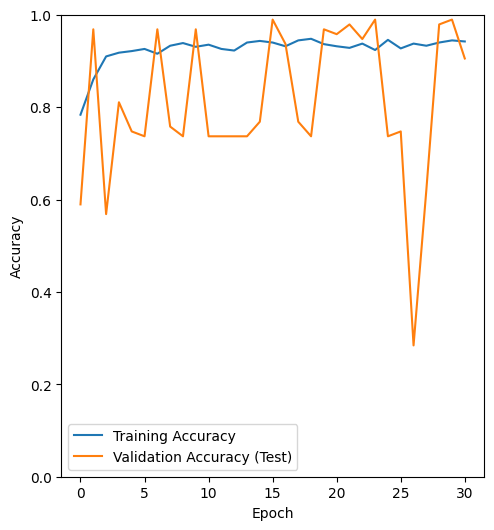

In [ ]:
# CNN       0.85
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_generator,
                    epochs=50,
                     callbacks=[es_callback, reduce_lr],
                     validation_data=validation_generator,
                     verbose=1)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training accuracy and validation accuracy (test accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])


plt.show()

Epoch 1/20
2/2 [==============================] - 3s 200ms/step - loss: 0.6894 - accuracy: 0.6400 - val_loss: 1.0086 - val_accuracy: 0.7604
Epoch 2/20
2/2 [==============================] - 0s 46ms/step - loss: 0.8165 - accuracy: 0.7000 - val_loss: 1.2002 - val_accuracy: 0.7604
Epoch 3/20
2/2 [==============================] - 0s 46ms/step - loss: 1.1309 - accuracy: 0.7000 - val_loss: 1.0629 - val_accuracy: 0.7604
Epoch 4/20
2/2 [==============================] - 0s 43ms/step - loss: 1.2818 - accuracy: 0.7600 - val_loss: 0.8465 - val_accuracy: 0.7604
Epoch 5/20
2/2 [==============================] - 0s 45ms/step - loss: 0.9713 - accuracy: 0.7600 - val_loss: 0.6995 - val_accuracy: 0.7604
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 0.8815 - accuracy: 0.7600 - val_loss: 0.6135 - val_accuracy: 0.7604
Epoch 7/20
2/2 [==============================] - 0s 46ms/step - loss: 1.2977 - accuracy: 0.7600 - val_loss: 0.5588 - val_accuracy: 0.7604
Epoch 8/20
2/2 [==========

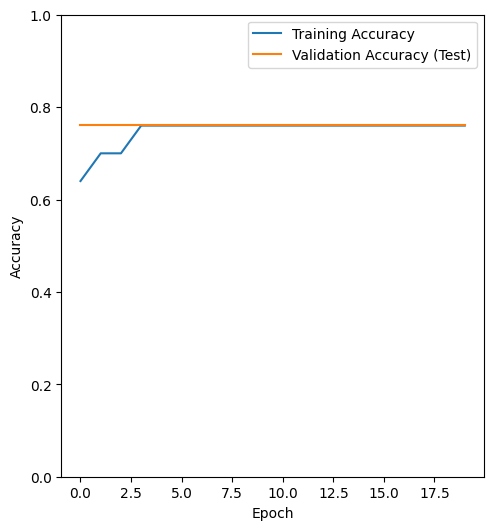

In [ ]:
#ANN

import tensorflow as tf
from tensorflow.keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Function to load images and labels from your directory structure
def load_data(directory):
    data = []
    labels = []

    label_mapping = {'Good': 1, 'Bad': 0}  # Define a mapping for your class labels

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = load_img(img_path, target_size=(32, 32))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            data.append(img_array)
            labels.append(label_mapping[label])

    return np.array(data), np.array(labels)


# Paths and sizes
train_data_dir = "/content/drive/MyDrive/GP/train-test/training_data"
test_data_dir = "/content/drive/MyDrive/GP/train-test/testing_data"

# Load training and test data
X_train, y_train = load_data(train_data_dir)
X_test, y_test = load_data(test_data_dir)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# ANN Model
model_ann = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.9),  # Higher dropout rate
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_ann.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model on a smaller subset of the training set
history_ann = model_ann.fit(X_train[:50], y_train[:50], epochs=20, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model_ann.evaluate(X_test, y_test)


# Print the test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Plot training accuracy and validation accuracy (test accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

# Show the plot
plt.show()


8/8 [==============================] - 0s 2ms/step


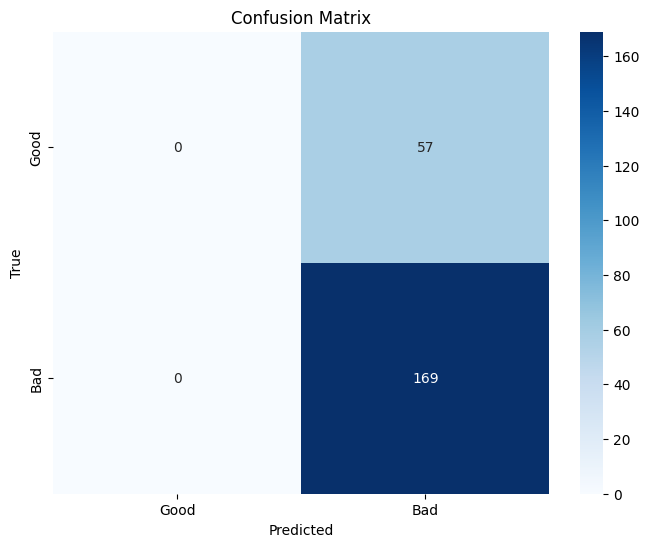

Classification Report:
               precision    recall  f1-score   support

        Good       0.00      0.00      0.00        57
         Bad       0.75      1.00      0.86       169

    accuracy                           0.75       226
   macro avg       0.37      0.50      0.43       226
weighted avg       0.56      0.75      0.64       226



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load test data using the load_data function
X_test, y_test = load_data("/content/drive/MyDrive/GP/train-test/testing_data")

# Predict on the test data
y_pred = model_ann.predict(X_test)
y_pred_classes = np.round(y_pred)

# Assuming the labels are already numerical (0 and 1)
y_true = y_test

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=["Good", "Bad"])
print("Classification Report:\n", class_report)
